### One layer integral

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

def lognormal_pdf(sigma, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
    """
    Compute the probability density function (PDF) of a Log-Normal distribution.

    Parameters:
    - sigma (float or ndarray): The variable(s) at which to evaluate the PDF. Must be positive.
    - P_mean (float): The mean (μ) of the underlying normal distribution.
    - P_std (float): The standard deviation (σ) of the underlying normal distribution.

    Returns:
    - float or ndarray: The value of the PDF at the given sigma.
    
    Raises:
    - ValueError: If any value in sigma is not positive or if P_std is not positive.
    """
    sigma = np.asarray(sigma)  # Ensure sigma is a NumPy array for element-wise operations

    if np.any(sigma <= 0):
        raise ValueError("All sigma values must be positive.")
    if P_std <= 0:
        raise ValueError("P_std (standard deviation) must be positive.")

    # Compute the PDF
    coefficient = 1 / (sigma * P_std * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((np.log(sigma) - P_mean) / P_std) ** 2
    pdf = coefficient * np.exp(exponent)
    return pdf


def psi_k(sigma_, tau, lambda_k, q_k, eta, eta_scaling=lambda sigma_: 1, data_scaling=lambda sigma_: 1):
    """
    Compute the value of ψ_k(λ; τ).

    Parameters:
    - lam: Integration variable λ
    - tau: Parameter τ
    - lambda_k: Parameter λ_k
    - q_k: Parameter q_k
    - eta: Parameter η
    - c_out: Parameter c_out
    - w_eff: Parameter w_eff

    Returns:
    - Value of ψ_k(λ; τ)
    """
    term1 = lambda_k / (sigma_**2 + lambda_k)
    term2 = q_k - (lambda_k / (sigma_**2 + lambda_k))
    exponent = -2 * eta * tau * eta_scaling(sigma_) * (sigma_**2 + lambda_k) * data_scaling(sigma_)**2 # (c_out**2) * w_eff
    return term1 + term2 * np.exp(exponent)

def integrand(sigma_, tau, lambda_k, q_k, eta, eta_scaling=lambda sigma_: 1, data_scaling=lambda sigma_: 1):
    """
    Compute the integrand [ψ_k(λ; τ) - 1] / λ.

    Parameters:
    - lam: Integration variable λ
    - tau, lambda_k, q_k, eta, c_out, w_eff: Parameters

    Returns:
    - Value of the integrand at λ
    """
    psi = psi_k(sigma_, tau, lambda_k, q_k, eta, eta_scaling, data_scaling)
    return (psi - 1) / sigma_

def compute_Phi(sigma, tau, lambda_k, q_k, eta, eta_scaling=lambda sigma_: 1, data_scaling=lambda sigma_: 1, sigma_ref=0.0002):
    """
    Compute Φ(σ; τ) using numerical integration.

    Parameters:
    - sigma: Upper limit of integration σ
    - tau, lambda_k, q_k, eta, c_out, w_eff: Parameters

    Returns:
    - Value of Φ(σ; τ)
    """
    # Define the integrand with fixed parameters
    integrand_func = lambda sigma_: integrand(sigma_, tau, lambda_k, q_k, eta, eta_scaling)
    
    # Perform the integration from 0 to sigma
    # 'quad' handles the potential singularity at lam=0
    integral, error = quad(integrand_func, sigma_ref, sigma, limit=10000, epsabs=1e-7, epsrel=1e-7)
    
    # Compute Φ(σ; τ)
    Phi = np.exp(-integral)
    return Phi

# Example Usage
if __name__ == "__main__":
    # Define parameters
    sigma_max = 100.0       # Example value for σ
    tau = 10         # Example value for τ
    lambda_k = 1.9    # Example value for λ_k
    q_k = 0.2         # Example value for q_k
    eta = 1.0         # Example value for η
    # c_out = 1.2       # Example value for c_out
    # w_eff = 0.8       # Example value for w_eff

    eta_scaling = lambda sigma_: lognormal_pdf(sigma_, P_mean=-1.2, P_std=1.2, sigma_data=0.5)
    # Compute Φ(σ; τ)
    Phi_value = compute_Phi(sigma_max, tau, lambda_k, q_k, eta, eta_scaling, sigma_ref=0.002)
    Phi_value_ref = compute_Phi(0.002, tau, lambda_k, q_k, eta, eta_scaling, sigma_ref=0.002)
    variance = sigma_max**2 * Phi_value_ref**2 / Phi_value**2
    print(f"Φ({sigma_max}; {tau}) = {Phi_value}")
    print(f"generated variance = {variance}")

Φ(100.0; 10) = 48.681551521803286
generated variance = 4.219598971353792


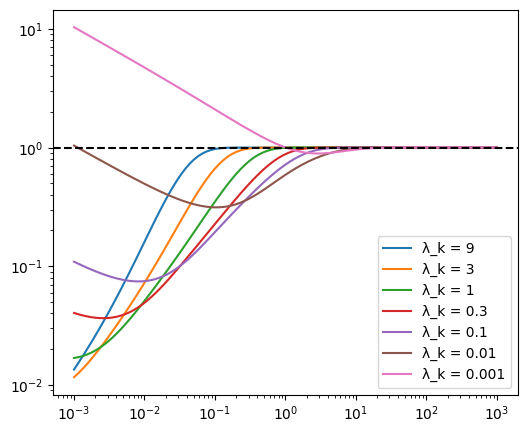

In [117]:
sigma_max = 100.0       # Example value for σ
sigma_min = 0.002
q_k = 0.5         # Example value for q_k
eta = 1.0         # Example value for η
# tau = 10         # Example value for τ
# c_out = 1.2       # Example value for c_out
# w_eff = 0.8       # Example value for w_eff
def weight_function(sigma, sigma_data=0.5):
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data)
# eta_scaling = lambda sigma_: sigma_ * lognormal_pdf(sigma_, P_mean=-1.2, P_std=1.2, sigma_data=0.5)
# eta_scaling = lambda sigma_: lognormal_pdf(sigma_, P_mean=-1.2, P_std=1.2, sigma_data=0.5)
eta_scaling = lambda sigma_: weight_function(sigma_, sigma_data=0.5)
# eta_scaling = lambda sigma_: 1 # lognormal_pdf(sigma_, P_mean=-1.2, P_std=1.2, sigma_data=0.5)
tau_arr = np.logspace(-3, 3, 100)
# lambda_k_values = [0.01, 0.1, 1, 10, 100]  # Example values for λ_k
lambda_k_values = reversed([0.001, 0.01, 0.1, .3, 1, 3, 9])  # Example values for λ_k
normalize = True
plt.figure(figsize=(6, 5))
for lambda_k in lambda_k_values:
    Phi_value_arr = []
    variance_arr = []
    for tau in tau_arr:
        # Compute Φ(σ; τ)
        Phi_sigma_T = compute_Phi(sigma_max, tau, lambda_k, q_k, eta, eta_scaling, sigma_ref=1)
        Phi_sigma_0 = compute_Phi(sigma_min, tau, lambda_k, q_k, eta, eta_scaling, sigma_ref=1)
        variance = sigma_max**2 * Phi_sigma_0**2 / Phi_sigma_T**2
        Phi_value_arr.append(Phi_value)
        variance_arr.append(variance)
    # plt.plot(tau_arr, Phi_value_arr)
    variance_arr = np.array(variance_arr)
    if normalize:
        normalized_variance_arr = variance_arr / lambda_k
        plt.plot(tau_arr, normalized_variance_arr, label=f'λ_k = {lambda_k}')
    else:
        plt.plot(tau_arr, variance_arr, label=f'λ_k = {lambda_k}')
        plt.axhline(y=lambda_k, color='r', linestyle='--')

if normalize:
    plt.axhline(y=1, color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

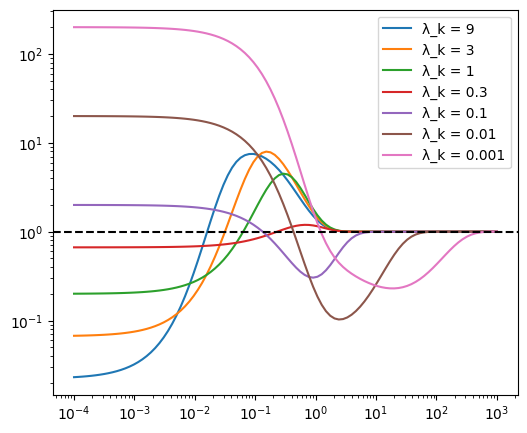

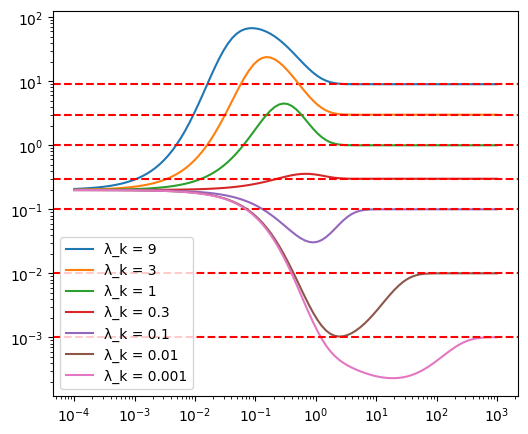

In [133]:
def compute_curves(sigma_max, sigma_min, q_k, eta, eta_scaling, data_scaling, tau_arr, lambda_k_values):
    results = []
    for lambda_k in lambda_k_values:
        Phi_value_arr = []
        variance_arr = []
        for tau in tau_arr:
            # Compute Φ(σ; τ)
            Phi_sigma_T = compute_Phi(sigma_max, tau, lambda_k, q_k, eta, eta_scaling, data_scaling, sigma_ref=1)
            Phi_sigma_0 = compute_Phi(sigma_min, tau, lambda_k, q_k, eta, eta_scaling, data_scaling, sigma_ref=1)
            variance = sigma_max**2 * Phi_sigma_0**2 / Phi_sigma_T**2
            Phi_value_arr.append(Phi_sigma_T)  # Assuming Phi_value is Phi_sigma_T
            variance_arr.append(variance)
        results.append((lambda_k, np.array(Phi_value_arr), np.array(variance_arr)))
    return results

def plot_curves(results, tau_arr, normalize=True):
    plt.figure(figsize=(6, 5))
    for lambda_k, Phi_value_arr, variance_arr in results:
        if normalize:
            normalized_variance_arr = variance_arr / lambda_k
            plt.plot(tau_arr, normalized_variance_arr, label=f'λ_k = {lambda_k}')
        else:
            plt.plot(tau_arr, variance_arr, label=f'λ_k = {lambda_k}')
            plt.axhline(y=lambda_k, color='r', linestyle='--')

    if normalize:
        plt.axhline(y=1, color='k', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Parameters
import math
sigma_max = 100.0
sigma_min = 0.002
q_k = 0.5
eta = 1.0
eta_scaling = lambda sigma_: 1 / math.sqrt(sigma_**2 + 0.5**2)**2#weight_function(sigma_, sigma_data=0.5)
# eta_scaling = lambda sigma_: weight_function(sigma_, sigma_data=0.5)
# data_scaling = lambda sigma_: 1 / math.sqrt(sigma_**2 + 0.5**2)
data_scaling = lambda sigma_: 1
tau_arr = np.logspace(-4, 3, 100)
lambda_k_values = reversed([0.001, 0.01, 0.1, .3, 1, 3, 9])

# Compute and plot
results = compute_curves(sigma_max, sigma_min, q_k, eta, eta_scaling, data_scaling, tau_arr, lambda_k_values)
plot_curves(results, tau_arr, normalize=True)
plot_curves(results, tau_arr, normalize=False)

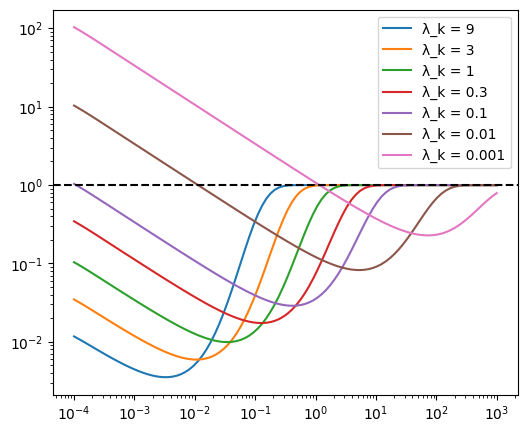

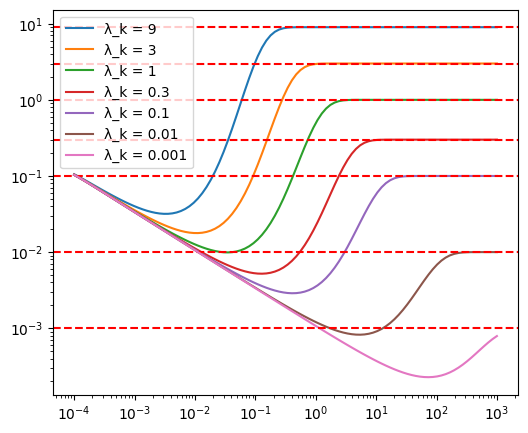

In [129]:
# Parameters
sigma_max = 100.0
sigma_min = 0.002
q_k = 0.5
eta = 1.0
# eta_scaling = lambda sigma_: weight_function(sigma_, sigma_data=0.5)
eta_scaling = lambda sigma_: 1
data_scaling = lambda sigma_: 1/ math.sqrt(sigma_**2 + 0.5**2)
tau_arr = np.logspace(-4, 3, 100)
lambda_k_values = reversed([0.001, 0.01, 0.1, .3, 1, 3, 9])

# Compute and plot
results = compute_curves(sigma_max, sigma_min, q_k, eta, eta_scaling, data_scaling, tau_arr, lambda_k_values)
plot_curves(results, tau_arr, normalize=True)
plot_curves(results, tau_arr, normalize=False)

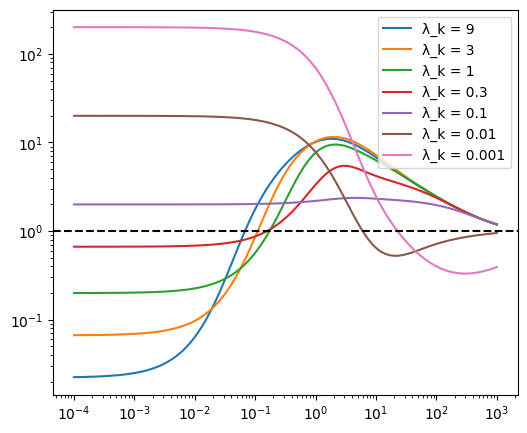

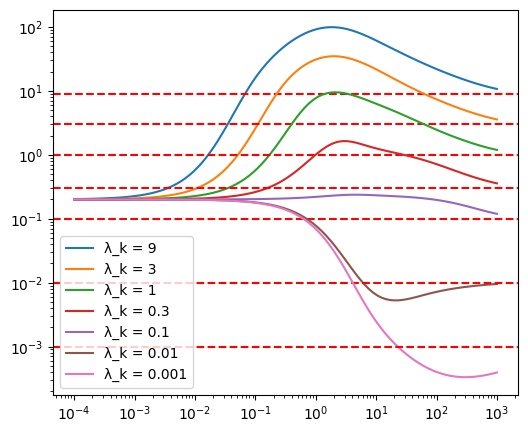

In [130]:
# Parameters
sigma_max = 100.0
sigma_min = 0.002
q_k = 0.5
eta = 1.0
# eta_scaling = lambda sigma_: weight_function(sigma_, sigma_data=0.5)
eta_scaling = lambda sigma_: lognormal_pdf(sigma_, P_mean=-1.2, P_std=1.2, sigma_data=0.5)
data_scaling = lambda sigma_: 1/ math.sqrt(sigma_**2 + 0.5**2)
tau_arr = np.logspace(-4, 3, 100)
lambda_k_values = reversed([0.001, 0.01, 0.1, .3, 1, 3, 9])

# Compute and plot
results = compute_curves(sigma_max, sigma_min, q_k, eta, eta_scaling, data_scaling, tau_arr, lambda_k_values)
plot_curves(results, tau_arr, normalize=True)
plot_curves(results, tau_arr, normalize=False)

### Two layer linear networks

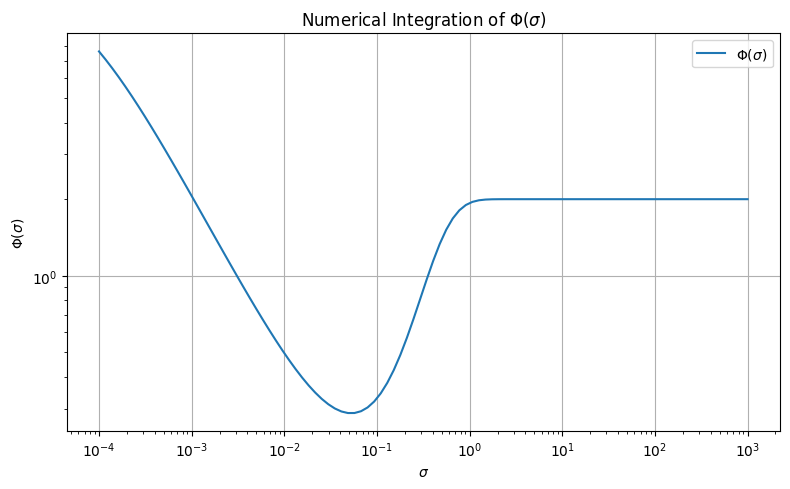

In [189]:
import numpy as np
from scipy.integrate import quad

def psi_k(sigma, tau, lambda_k, Q_k, eta=1, eta_scaling=lambda sigma_: 1, 
          weight_scaling=lambda sigma_: 1):# data_scaling=lambda sigma_: 1):
    """
    Compute the value of ψ_k(σ; τ).

    Parameters:
    - sigma (float): The variable σ. Must be positive.
    - tau (float): Parameter τ.
    - lambda_k (float): Parameter λ_k. Must be positive.
    - Q_k (float): Parameter Q_k. Must be positive.
    - eta (float): Parameter η. Must be non-negative.

    Returns:
    - float: Value of ψ_k(σ; τ)
    
    Raises:
    - ValueError: If any of the parameters are out of their valid ranges.
    """
    assert sigma > 0, "sigma must be positive."
    assert lambda_k > 0, "lambda_k must be positive."
    assert Q_k > 0, "Q_k must be positive."
    assert eta >= 0, "eta must be non-negative."

    denominator = sigma**2 + lambda_k
    term1 = lambda_k / denominator

    inner_fraction = (1 / Q_k * weight_scaling(sigma)) * (lambda_k / denominator) - 1
    exponent = -8 * eta * tau * lambda_k * eta_scaling(sigma)
    denominator_fraction = inner_fraction * np.exp(exponent) + 1

    # Avoid division by zero
    if denominator_fraction == 0:
        raise ZeroDivisionError("Denominator in ψ_k calculation is zero.")

    psi = term1 / denominator_fraction
    return psi

def integrand(sigma_prime, tau, lambda_k, Q_k, eta=1, eta_scaling=lambda sigma_: 1,
              weight_scaling=lambda sigma_: 1):
    """
    Compute the integrand [ψ_k(σ'; τ) - 1] / σ'.

    Parameters:
    - sigma_prime (float): Integration variable σ'. Must be positive.
    - tau, lambda_k, Q_k, eta: Parameters as defined in psi_k.

    Returns:
    - float: Value of the integrand at σ'
    
    Raises:
    - ValueError: If sigma_prime is not positive.
    """
    # if sigma_prime <= 0:
    # Handle the limit as sigma_prime approaches 0
    # Compute the limit of [ψ_k(sigma_prime; tau) - 1]/sigma_prime as sigma_prime -> 0
    # This requires evaluating ψ_k at sigma_prime = 0 analytically if possible
    # For simplicity, we can return a finite approximation or a very small value
    # Here, we'll assume that the limit exists and is finite
    # This needs to be verified based on the specific form of ψ_k
    # Alternatively, adjust the integration lower limit to a small positive number
    # raise ValueError("sigma_prime must be positive and greater than 0.")
    assert sigma_prime > 0, "sigma_prime must be positive and greater than 0."
    
    psi = psi_k(sigma_prime, tau, lambda_k, Q_k, eta, eta_scaling, weight_scaling)
    return (psi - 1) / sigma_prime

def compute_Phi(sigma, tau, lambda_k, Q_k, eta=1, eta_scaling=lambda sigma_: 1, weight_scaling=lambda sigma_: 1, sigma_ref=1.0):
    """
    Compute Φ(σ) using numerical integration.

    Parameters:
    - sigma (float): Upper limit of integration σ. Must be positive.
    - tau (float): Parameter τ.
    - lambda_k (float): Parameter λ_k. Must be positive.
    - Q_k (float): Parameter Q_k. Must be positive.
    - eta (float): Parameter η. Must be non-negative.

    Returns:
    - float: Value of Φ(σ)
    
    Raises:
    - ValueError: If sigma is not positive.
    """
    if sigma <= 0:
        raise ValueError("sigma must be positive.")

    # Define the integrand with fixed parameters
    integrand_func = lambda sigma_prime: integrand(sigma_prime, tau, lambda_k, Q_k, eta, eta_scaling, weight_scaling)
    
    # Perform the integration from a small positive number to sigma to avoid sigma_prime=0
    # Choose a small epsilon, e.g., 1e-8
    # epsilon = 1e-8
    try:
        integral, error = quad(
            integrand_func,
            sigma_ref,
            sigma,
            limit=1000,
            epsabs=1e-10,
            epsrel=1e-10
        )
    except Exception as e:
        raise RuntimeError(f"Numerical integration failed: {e}")

    # Compute Φ(σ)
    Phi = np.exp(-integral)
    return Phi

def compute_Phi_vectorized(tau_array, sigma, lambda_k, Q_k, eta=1, eta_scaling=lambda sigma_: 1, weight_scaling=lambda sigma_: 1):
    """
    Compute Φ(σ) for an array of σ values.

    Parameters:
    - sigma_array (array-like): Array of σ values. All must be positive.
    - tau (float): Parameter τ.
    - lambda_k (float): Parameter λ_k. Must be positive.
    - Q_k (float): Parameter Q_k. Must be positive.
    - eta (float): Parameter η. Must be non-negative.

    Returns:
    - ndarray: Array of Φ(σ) values corresponding to sigma_array
    """
    Phi_values = []
    for tau in tau_array:
        try:
            Phi = compute_Phi(sigma, tau, lambda_k, Q_k, eta, eta_scaling, weight_scaling)
            Phi_values.append(Phi)
        except Exception as e:
            print(f"Failed to compute Phi for sigma={sigma}: {e}")
            Phi_values.append(np.nan)
    return np.array(Phi_values)

# Example Usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Define parameters
    tau = 0.5         # Example value for τ
    lambda_k = 2.0    # Example value for λ_k
    Q_k = .7         # Example value for Q_k
    eta = 0.3         # Example value for η

    # Define sigma values
    # tau_values = np.linspace(0.01, 5, 500)  # Avoid sigma=0 to prevent division by zero
    sigma_T = 100
    sigma_0 = 0.002
    tau_values = np.logspace(-4, 3, 100)
    # Compute Phi values
    Phi_sigma_T_values = compute_Phi_vectorized(tau_values, sigma_T, lambda_k, Q_k, eta)
    Phi_sigma_0_values = compute_Phi_vectorized(tau_values, sigma_0, lambda_k, Q_k, eta)
    variance = sigma_T**2 * Phi_sigma_0_values**2 / Phi_sigma_T_values**2
    # Plot Φ(σ)
    plt.figure(figsize=(8, 5))
    plt.plot(tau_values, variance, label=r'$\Phi(\sigma)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(r'Numerical Integration of $\Phi(\sigma)$')
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'$\Phi(\sigma)$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # # Example: Compute Phi at a specific sigma
    # sigma_specific = 1.0
    # try:
    #     Phi_specific = compute_Phi(sigma_specific, tau, lambda_k, Q_k, eta)
    #     print(f"Φ({sigma_specific}) = {Phi_specific:.5f}")
    # except Exception as e:
    #     print(f"Failed to compute Phi for sigma={sigma_specific}: {e}")

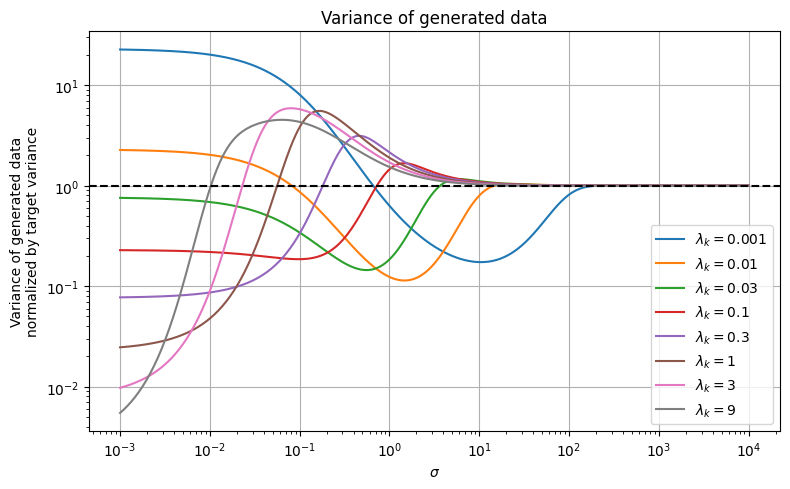

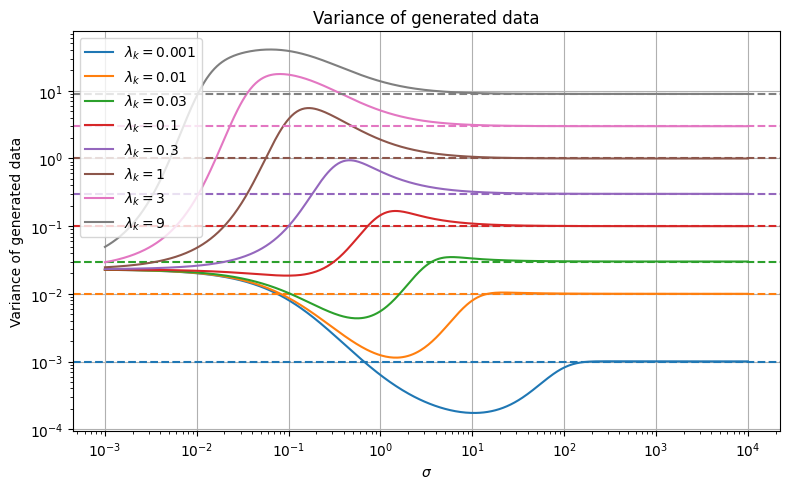

In [188]:

import matplotlib.pyplot as plt
import numpy as np
import math

def compute_variance_values(tau_values, sigma_T, sigma_0, lambda_k_values, Q_k, eta, eta_scaling, weight_scaling):
    variance_results = {}
    for lambda_k in lambda_k_values:
        Phi_sigma_T_values = compute_Phi_vectorized(tau_values, sigma_T, lambda_k, Q_k, eta, eta_scaling, weight_scaling)
        Phi_sigma_0_values = compute_Phi_vectorized(tau_values, sigma_0, lambda_k, Q_k, eta, eta_scaling, weight_scaling)
        variance = sigma_T**2 * Phi_sigma_0_values**2 / Phi_sigma_T_values**2
        variance_results[lambda_k] = variance
    return variance_results

def plot_variance(tau_values, variance_results, normalize=True):
    plt.figure(figsize=(8, 5))
    for i, (lambda_k, variance) in enumerate(variance_results.items()):
        if normalize:
            plt.plot(tau_values, variance / lambda_k, label=f'$\lambda_k = {lambda_k}$', color=f'C{i}')
        else:
            plt.plot(tau_values, variance, label=f'$\lambda_k = {lambda_k}$', color=f'C{i}')
            plt.axhline(y=lambda_k, color=f'C{i}', linestyle='--')
    if normalize:
        plt.axhline(y=1, color='k', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(r'Variance of generated data')
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'Variance of generated data' + ('\nnormalized by target variance' if normalize else ''))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define parameters
Q_k = 0.4
sigma_T = 100
sigma_0 = 0.002
# eta = 1E-3
# tau_values = np.logspace(1, 5, 500)
eta = 1
tau_values = np.logspace(-3, 4, 500)
eta_scaling = lambda sigma_: 1 / (sigma_**2 + 0.5**2) * 1#sigma_ * lognormal_pdf(sigma_, P_mean=-1.2, P_std=1.2, sigma_data=0.5)
weight_scaling = lambda sigma_: (sigma_ * 0.5) / (sigma_**2 + 0.5**2)
lambda_k_values = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 9]
# Compute variance values
variance_results = compute_variance_values(tau_values, sigma_T, sigma_0, lambda_k_values, Q_k, eta, eta_scaling)
# Plot variance
plot_variance(tau_values, variance_results, normalize=True)
plot_variance(tau_values, variance_results, normalize=False)

In [48]:
Phi_value_ref

1.3715737174129334

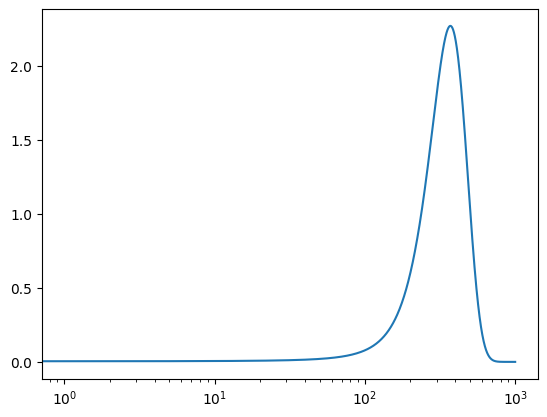

In [40]:

eta_scaling = lambda sigma_: lognormal_pdf(sigma_, P_mean=-1.2, P_std=1.2, sigma_data=0.5)
plt.plot(eta_scaling(np.logspace(-3, 2, 1000)))
plt.xscale('log')